# data load and overflow

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [25]:
df = pd.read_csv("./data/df_train.csv")
test = pd.read_csv("./data/df_test.csv")

# data clean

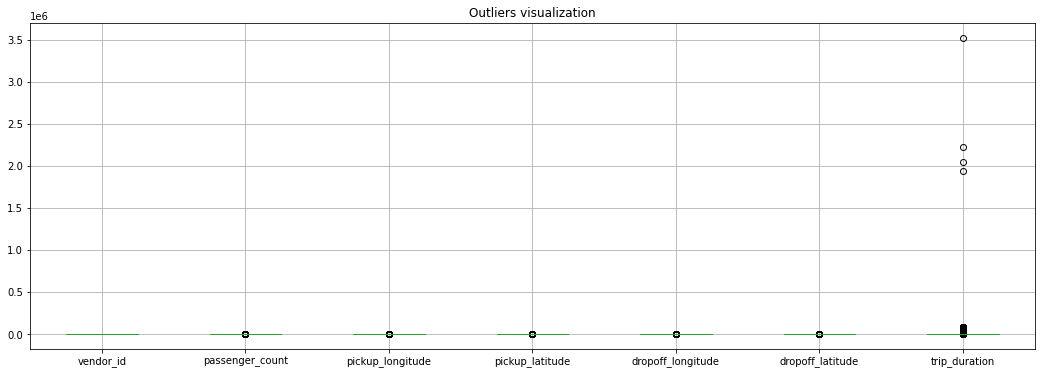

In [26]:
#Visualize univariate outliers
plt.subplots(figsize=(18,6))
plt.title("Outliers visualization")
df.boxplot();

In [27]:
df.size

16045084

In [28]:
#Only keep trips that lasted less than 5900 seconds
df = df[(df.trip_duration < 5900)]
df.size

16016176

In [29]:
#Only keep trips that lasted less than 5900 seconds
df = df[(df.trip_duration < 5900)]

#Only keep trips with passengers
df = df[(df.passenger_count > 0)]

In [30]:
#Remove position outliers
df = df[(df.pickup_longitude > -100)]
df = df[(df.pickup_latitude < 50)]
df = df[(df.dropoff_longitude < -70) & (df.dropoff_longitude > -80)]
df = df[(df.dropoff_latitude < 50)]

# feature engineer

In [31]:
df.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,455


In [32]:
#One-hot encoding binary categorical features
df = pd.concat([df, pd.get_dummies(df['store_and_fwd_flag'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['store_and_fwd_flag'])], axis=1)

df.drop(['store_and_fwd_flag'], axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['vendor_id'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['vendor_id'])], axis=1)

df.drop(['vendor_id'], axis=1, inplace=True)

In [33]:
#Datetyping the dates
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

df.drop(['dropoff_datetime'], axis=1, inplace=True) #as we don't have this feature in the testset

#Date features creations and deletions
df['month'] = df.pickup_datetime.dt.month
df['week'] = df.pickup_datetime.dt.week
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour
df['minute'] = df.pickup_datetime.dt.minute
df['minute_oftheday'] = df['hour'] * 60 + df['minute']
df.drop(['minute'], axis=1, inplace=True)

test['month'] = test.pickup_datetime.dt.month
test['week'] = test.pickup_datetime.dt.week
test['weekday'] = test.pickup_datetime.dt.weekday
test['hour'] = test.pickup_datetime.dt.hour
test['minute'] = test.pickup_datetime.dt.minute
test['minute_oftheday'] = test['hour'] * 60 + test['minute']
test.drop(['minute'], axis=1, inplace=True)

df.drop(['pickup_datetime'], axis=1, inplace=True)

# df.info()

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_2372/3263461535.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df.pickup_datetime.dt.week
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_2372/3263461535.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test['week'] = test.pickup_datetime.dt.week


In [34]:
#Function aiming at calculating distances from coordinates
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

#Add distance feature
df['distance'] = ft_haversine_distance(df['pickup_latitude'].values,
                                                 df['pickup_longitude'].values, 
                                                 df['dropoff_latitude'].values,
                                                 df['dropoff_longitude'].values)
test['distance'] = ft_haversine_distance(test['pickup_latitude'].values, 
                                                test['pickup_longitude'].values, 
                                                test['dropoff_latitude'].values, 
                                                test['dropoff_longitude'].values)

In [35]:
#Function aiming at calculating the direction
def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

#Add direction feature
df['direction'] = ft_degree(df['pickup_latitude'].values,
                                df['pickup_longitude'].values,
                                df['dropoff_latitude'].values,
                                df['dropoff_longitude'].values)
test['direction'] = ft_degree(test['pickup_latitude'].values,
                                  test['pickup_longitude'].values, 
                                  test['dropoff_latitude'].values,
                                  test['dropoff_longitude'].values)

26206902

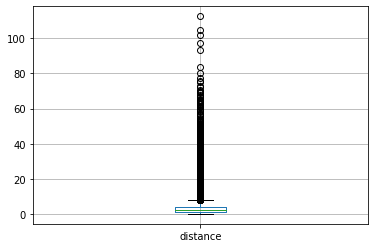

In [40]:
#Visualize distance outliers
df.boxplot(column='distance', return_type='axes');
df.size

In [39]:
#Remove distance outliers
df = df[(df.distance < 200)]
df.size

26206902

In [46]:
#Visualize distance outliers
df.head(5)

,id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,N,Y,1,2,month,week,weekday,hour,minute_oftheday,distance,direction,speed
0,id2875421,1,-73.982155,40.767937,-73.964630,40.765602,455,1,0,0,1,3,11,0,17,1044,1.498521,99.970196,11.856428
1,id2377394,1,-73.980415,40.738564,-73.999481,40.731152,663,1,0,1,0,6,23,6,0,43,1.805507,-117.153768,9.803659
2,id3858529,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,0,0,1,1,3,1,11,695,6.385098,-159.680165,10.822201
3,id3504673,1,-74.010040,40.719971,-74.012268,40.706718,429,1,0,0,1,4,14,2,19,1172,1.485498,-172.737700,12.465721
4,id2181028,1,-73.973053,40.793209,-73.972923,40.782520,435,1,0,0,1,3,12,5,13,810,1.188588,179.473585,9.836594


In [45]:
#Create speed feature
df['speed'] = df.distance * 3600 / df.trip_duration

In [ ]:
#Visualize speed feature
df.boxplot(column='speed', return_type='axes');

In [48]:
#Remove speed outliers
df = df[(df.speed < 30)]
df.drop(['speed'], axis=1, inplace=True)

# model selection

In [51]:
df.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,N,Y,1,2,month,week,weekday,hour,minute_oftheday,distance,direction
count,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06,1.388395e+06
mean,1.664511e+00,-7.397544e+01,4.075165e+01,-7.397505e+01,4.075169e+01,8.250716e+02,9.945995e-01,5.400480e-03,4.659474e-01,5.340526e-01,3.520865e+00,1.382013e+01,3.041081e+00,1.371302e+01,8.523762e+02,3.081797e+00,-1.575013e+01
std,1.313706e+00,3.551229e-02,2.765982e-02,3.297707e-02,3.087944e-02,6.428504e+02,7.328928e-02,7.328928e-02,4.988393e-01,4.988393e-01,1.680635e+00,8.500028e+00,1.944793e+00,6.294446e+00,3.779763e+02,3.276822e+00,1.051399e+02
min,1.000000e+00,-7.948790e+01,3.602930e+01,-7.948790e+01,3.602930e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.799927e+02
25%,1.000000e+00,-7.399204e+01,4.073785e+01,-7.399146e+01,4.073638e+01,3.970000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,7.000000e+00,1.000000e+00,9.000000e+00,5.860000e+02,1.209653e+00,-1.264802e+02
50%,1.000000e+00,-7.398199e+01,4.075417e+01,-7.398026e+01,4.075441e+01,6.530000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.300000e+01,3.000000e+00,1.400000e+01,8.920000e+02,2.024030e+00,7.552413e+00
75%,2.000000e+00,-7.396822e+01,4.076822e+01,-7.396458e+01,4.076912e+01,1.050000e+03,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00,2.000000e+01,5.000000e+00,1.900000e+01,1.166000e+03,3.601693e+00,5.447296e+01
max,9.000000e+00,-7.051190e+01,4.391176e+01,-7.051190e+01,4.391176e+01,5.897000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,5.300000e+01,6.000000e+00,2.300000e+01,1.439000e+03,4.352663e+01,1.800000e+02


## split

In [52]:
#Split the labeled data frame into two sets: features and target
y = df["trip_duration"]
df.drop(["trip_duration"], axis=1, inplace=True)
df.drop(['id'], axis=1, inplace=True)
X = df

X.shape, y.shape

((1388395, 16), (1388395,))

In [55]:
#Split the labeled data frame into two sets to train then test the models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2345)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1110716, 16), (1110716,), (277679, 16), (277679,))

## metrics

In [56]:
from sklearn.metrics import mean_squared_error as MSE

## model

In [18]:
#%%time
#Try GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
print(gb.score(X_train, y_train), gb.score(X_test, y_test))
print(np.sqrt(MSE(y_test, gb.predict(X_test))))
    
#Output
    #0.7454771059776502 0.7443578507676307
    #0.39291173774102295
    #CPU times: user 3min 48s, sys: 328 ms, total: 3min 48s
    #Wall time: 3min 48s

E:\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
E:\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
E:\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.7464809677157271 0.7456702259553296


E:\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


327.27356976999715


In [19]:
#%%time
#Try RandomForest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train), rf.score(X_test, y_test))
print(np.sqrt(MSE(y_test, rf.predict(X_test))))

#Output:
    #0.9601197799928392 0.7790255381297454
    #0.36530012047088345
    #CPU times: user 3min, sys: 792 ms, total: 3min 1s
    #Wall time: 3min 1s

E:\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
E:\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
E:\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.9738750467739886 0.8142258465132695


E:\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


279.708057000626


In [20]:
#%%time
#Try LightGBM ----------------------------
import lightgbm as lgb

lgb_params = {
   'metric': 'rmse',
   'is_training_metric': True}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=100, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=5)

#Output
    #[100]	valid_0's rmse: 0.362209	valid_1's rmse: 0.3629
    #CPU times: user 40.9 s, sys: 332 ms, total: 41.2 s
    #Wall time: 21.2 s

#Try LightGBM with sklearn API ------------
from lightgbm import LGBMRegressor

lgbm = lgb.LGBMRegressor()
lgbm.fit(X, y)
print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test))
print(np.sqrt(MSE(y_test, lgbm.predict(X_test))))

#Output:
    #0.7812886118508641 0.7827256176145024
    #0.3623481127815768
    #CPU times: user 42 s, sys: 1.08 s, total: 43 s
    #Wall time: 22.5 s

E:\Miniconda3\envs\myenv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1866
[LightGBM] [Info] Number of data points in the train set: 1164755, number of used features: 16
[LightGBM] [Info] Start training from score 834.677624
[1]	training's rmse: 604.27	valid_1's rmse: 605.131
Training until validation scores don't improve for 5 rounds
[2]	training's rmse: 566.007	valid_1's rmse: 566.924
[3]	training's rmse: 532.762	valid_1's rmse: 533.767
[4]	training's rmse: 503.844	valid_1's rmse: 504.955
[5]	training's rmse: 479.024	valid_1's rmse: 480.189
[6]	training's rmse: 457.592	valid_1's rmse: 458.807
[7]	training's rmse: 439.255	valid_1's rmse: 440.479
[8]	training's rmse: 423.63	valid_1's rmse: 424.884
[9]	training's rmse: 410.255	valid_1's rmse: 411.502
[10]	training's rmse: 398.756	valid_1's rmse: 399.97

## cross validation

In [21]:
#Cross-validation on LightGBM model --------------------------
lgb_df = lgb.Dataset(X, y)
lgb.cv(lgb_params, lgb_df, stratified=False) #False is needed as it only works with classification

#Cross-validation on LightGBM model (sklearn API) ------------
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(lgbm, X, y, cv=5)
print(cv_score)
print(np.mean(cv_score))

#Output:
    #[0.77872018 0.7801329  0.77988107 0.78049745 0.77904688]
    #0.7796556968369478

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 1164752, number of used features: 16
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 1164752, number of used features: 16
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Num

# hyparameters tuning

In [ ]:
#Hyperparameters tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 16)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

random_cv = RandomizedSearchCV(estimator = m1, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
print(random_cv.best_params_)

In [22]:
#Test the following parameters
lgb_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=1500, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=5)

E:\Miniconda3\envs\myenv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6999
[LightGBM] [Info] Number of data points in the train set: 1164755, number of used features: 16
[LightGBM] [Info] Start training from score 834.677624
[1]	training's l2: 358650	valid_1's l2: 359964
Training until validation scores don't improve for 5 rounds
[2]	training's l2: 311048	valid_1's l2: 312552
[3]	training's l2: 269759	valid_1's l2: 271414
[4]	training's l2: 235944	valid_1's l2: 237820
[5]	training's l2: 209764	valid_1's l2: 211779
[6]	training's l2: 186831	valid_1's l2: 189029
[7]	training's l2: 168002	valid_1's l2: 170419
[8]	training's l2: 153550	valid_1's l2: 156160
[9]	training's l2: 141631	valid_1's l2: 144396
[10]	training's l2: 130915	valid_1's l2: 133846
[11]	training's l2: 121834	valid_1's l2: 124929
[12]	training's l2: 114287	valid_1's l2: 117584
[13]	training's l2: 1079

# training and prediction

In [23]:
#%%time
#Training on all labeled data using the best parameters in hyperparameters tuning
rf = RandomForestRegressor(n_estimators=300, min_samples_leaf=10, min_samples_split=15, max_features='auto', max_depth=90, bootstrap=True)
rf.fit(X, y)

E:\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestRegressor(max_depth=90, min_samples_leaf=10, min_samples_split=15,
                      n_estimators=300)

In [24]:
#%%time
#Training on all labeled data using the best parameters (sklearn API version)
from lightgbm import LGBMRegressor

lgbm = lgb.LGBMRegressor(n_estimators=500, num_leaves=1000, max_depth=25, objective='regression')
lgbm.fit(X, y)

LGBMRegressor(max_depth=25, n_estimators=500, num_leaves=1000,
              objective='regression')

In [25]:
%%time
#Training on all labeled data using the best parameters
lgb_df = lgb.Dataset(X, y)
lgb_model = lgb.train(lgb_params, lgb_df, num_boost_round=1500)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7006
[LightGBM] [Info] Number of data points in the train set: 1455944, number of used features: 16
[LightGBM] [Info] Start training from score 834.670109
Wall time: 1min 56s


In [26]:
#Make predictions on test data frame
test_columns = X.columns
predictions = lgb_model.predict(test[test_columns])

In [35]:
predictions

array([ 718.62445889,  822.46375252,  489.44081966, ..., 1839.52794045,
       2182.7457362 , 1141.86572916])

In [36]:
np.exp([1])

array([2.71828183])

In [37]:
#Create a data frame designed a submission on Kaggle
submission = pd.DataFrame({'id': test.id, 'trip_duration': predictions})
submission.head()

,id,trip_duration
0,id3004672,718.624459
1,id3505355,822.463753
2,id1217141,489.440820
3,id2150126,1130.830400
4,id1598245,391.433988


In [28]:
#Create a csv out of the submission data frame
submission.to_csv("sub.csv", index=False)